
<a id='seir-model'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Modeling COVID 19 with Differential Equations

## Contents

- [Modeling COVID 19 with Differential Equations](#Modeling-COVID-19-with-Differential-Equations)  
  - [Overview](#Overview)  
  - [The SEIR Model](#The-SEIR-Model)  
  - [Implementation](#Implementation)  
  - [Experiments](#Experiments)  
  - [Ending Lockdown](#Ending-Lockdown)  

## Overview

Coauthored with Chris Rackauckas

This is a Julia version of code for analyzing the COVID-19 pandemic.

The purpose of these notes is to introduce economists to quantitative modeling of infectious disease dynamics, and to modeling with ordinary differential
equations.

In this lecture, dynamics are modeled using a standard SEIR (Susceptible-Exposed-Infected-Removed) model
of disease spread, represented as a system of ordinary differential
equations where the number of agents is large and there are no exogenous stochastic shocks.

The first part of the model is inspired by
*  Notes from [Andrew Atkeson](https://sites.google.com/site/andyatkeson/) and [NBER Working Paper No. 26867](https://www.nber.org/papers/w26867)
* [Estimating and Forecasting Disease Scenarios for COVID-19 with an SIR Model](https://www.nber.org/papers/w27335) by Andrew Atkeson, Karen Kopecky and Tao Zha
* [Estimating and Simulating a SIRD Model of COVID-19 for Many Countries, States, and Cities](https://www.nber.org/papers/w27128) by Jesús Fernández-Villaverde and Charles I. Jones
* Further variations on the classic SIR model in Julia  [here](https://github.com/epirecipes/sir-julia).

We then extend this deterministic model in [this lecture](covid_sde.html) which build on this model, adding in aggregate shocks and policy tradeoffs.

The interest is primarily in

- studying the impact of suppression through social distancing on the spread of the infection  
- the number of infections at a given time (which determines whether or not the health care system is overwhelmed); and  
- how long the caseload can be deferred (hopefully until a vaccine arrives)  

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0")

In [2]:
using LinearAlgebra, Statistics, Random, SparseArrays

In addition, we will be exploring the [Ordinary Differential Equations](https://diffeq.sciml.ai/dev/tutorials/ode_example/) package within the [SciML ecosystem](https://github.com/SciML/).

In [3]:
using OrdinaryDiffEq
using Parameters, Plots

## The SEIR Model

In the version of the SEIR model, all individuals in the population are assumed to be in a finite number of states.

The states are: susceptible (S), exposed (E), infected (I) and removed (R).

This type of [compartmentalized model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#Elaborations_on_the_basic_SIR_model)  has many extensions (e.g. SEIRS relaxes lifetime immunity and allow transitions from $ R \to S $).

Comments:

- Those in state R have been infected and either recovered or died.  Note that in some variations, R may refer only to recovered agents.  
- Those who have recovered, and live, are assumed to have acquired immunity.  
- Those in the exposed group are not yet infectious.  

### Changes in the Infected State

Within the SEIR model, the flow across states follows the path $ S \to E \to I \to R $.

We will ignore birth and non-covid death during our time horizon, and assume a large, constant, number of individuals of size $ N $ throughout.

With this, the symbols $ S, E, I, R $ are used for the total number of individuals in each state at each point in time, and $ S(t) + E(t) + I(t) + R(t) = N $ for all $ t $.

Since we have  assumed that $ N $ is large, we can use a continuum approximation for the number of individuals in each state.

The transitions between those states are governed by the following rates

- $ \beta(t) $ is called the *transmission rate* or *effective contact rate* (the rate at which individuals bump into others and expose them to the virus).  
- $ \sigma $ is called the *infection rate* (the rate at which those who are exposed become infected)  
- $ \gamma $ is called the *recovery rate* (the rate at which infected people recover or die)  


The rate $ \beta(t) $ is influenced by both the characteristics of the disease (e.g. the type and length of prolonged contact required for a transmission) and behavior of the individuals (e.g. social distancing, hygiene).

The SEIR model can then be written as


<a id='equation-seir-system-big'></a>
$$
\begin{aligned}
     \frac{d S}{d t}  & = - \beta \, S \,  \frac{I}{N}
     \\
     \frac{d E}{d t}   & = \beta \, S \,   \frac{I}{N}  - \sigma E
     \\
      \frac{d I}{d t}  & = \sigma  E  - \gamma I
     \\
      \frac{d R}{d t}  & = \gamma  I
\end{aligned} \tag{1}
$$

Here, $ dy/dt $ represents the time derivative for the particular variable.

The first term of [(1)](#equation-seir-system-big), $ -\beta \, S \,  \frac{I}{N} $, is the flow of individuals moving from $ S \to E $, and highlights the underlying dynamics of the epidemic

- Individuals in the susceptible state (S) have a rate $ \beta(t) $ of prolonged contacts with other individuals where transmission would occur if either was infected  
- Of these contacts, a fraction $ \frac{I(t)}{N} $ will be with infected agents (since we assumed that exposed individuals are not yet infectious)  
- Finally, there are $ S(t) $ susceptible individuals.  
- The sign indicates that the product of those terms is the outflow from the $ S $ state, and an inflow to the $ E $ state.  

### Basic Reproduction Number

If $ \beta $ was constant, then we could define $ R_0 := \beta / \gamma $.  This is the famous *basic reproduction number* for the SEIR model.  See [[HSW05]](../zreferences.html#heffernan2005perspectives) for more details.

When the transmission rate is time-varying, we will follow notation in [[FVJ20]](../zreferences.html#nberw27128) and refer to $ R_0(t) $ as a time-varying version of the basic reproduction number.

Analyzing the system in [(1)](#equation-seir-system-big) provides some intuition on the $ R_0(t) := \beta(t) / \gamma $ expression:

- Individual transitions from the infected to removed state occur at a Poisson rate $ \gamma $, the expected time in the infected state is $ 1/\gamma $  
- Prolonged interactions occur at rate $ \beta $, so a new individual entering the infected state will potentially transmit the virus to an average of $ R_0 = \beta \times 1 / \gamma $ others  
- In more complicated models, see [[HSW05]](../zreferences.html#heffernan2005perspectives) for a formal definition for arbitrary models, and an analysis on the role of $ R_0 < 1 $.  


Note that the notation $ R_0 $ is standard in the epidemiology literature - though confusing, since $ R_0 $ is unrelated to $ R $, the symbol that represents the removed state.  For the remainder of the lecture, we will avoid using $ R $ for removed state.

Prior to solving the model directly, we make a few changes to [(1)](#equation-seir-system-big)

- Re-parameterize using $ \beta(t) = \gamma R_0(t) $  
- Define the proportion of individuals in each state as $ s := S/N $ etc.  
- Divide each equation in [(1)](#equation-seir-system-big) by $ N $, and write the system of ODEs in terms of the proportions  



<a id='equation-seir-system'></a>
$$
\begin{aligned}
     \frac{d s}{d t}  & = - \gamma \, R_0 \, s \,  i
     \\
     \frac{d e}{d t}   & = \gamma \, R_0 \, s \,  i  - \sigma e
     \\
      \frac{d i}{d t}  & = \sigma  e  - \gamma i
     \\
      \frac{d r}{d t}  & = \gamma  i
\end{aligned} \tag{2}
$$

Since the states form a partition, we could reconstruct the “removed” fraction of the population as $ r = 1 - s - e - i $.  However, keeping it in the system will make plotting more convenient.

### Implementation

We begin by implementing a simple version of this model with a constant $ R_0 $ and some baseline parameter values (which we discuss later).

First, define the system of equations

In [4]:
function F_simple(x, p, t; γ = 1/18, R₀ = 3.0, σ = 1/5.2)
    s, e, i, r = x

    return [-γ*R₀*s*i;       # ds/dt = -γR₀si
             γ*R₀*s*i -  σ*e;# de/dt =  γR₀si -σe
             σ*e - γ*i;      # di/dt =         σe -γi
                   γ*i;      # dr/dt =             γi
            ]
end

F_simple (generic function with 1 method)

Given this system, we choose an initial condition and a timespan, and create a `ODEProblem` encapsulating the system.

In [5]:
i_0 = 1E-7                  # 33 = 1E-7 * 330 million population = initially infected
e_0 = 4.0 * i_0             # 132 = 1E-7 *330 million = initially exposed
s_0 = 1.0 - i_0 - e_0
r_0 = 0.0
x_0 = [s_0, e_0, i_0, r_0]  # initial condition

tspan = (0.0, 350.0)  # ≈ 350 days
prob = ODEProblem(F_simple, x_0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 350.0)
u0: [0.9999995, 4.0e-7, 1.0e-7, 0.0]

With this, choose an ODE algorithm and solve the initial value problem.  A good default algorithm for non-stiff ODEs of this sort might be `Tsit5()`, which is the Tsitouras 5/4 Runge-Kutta method).

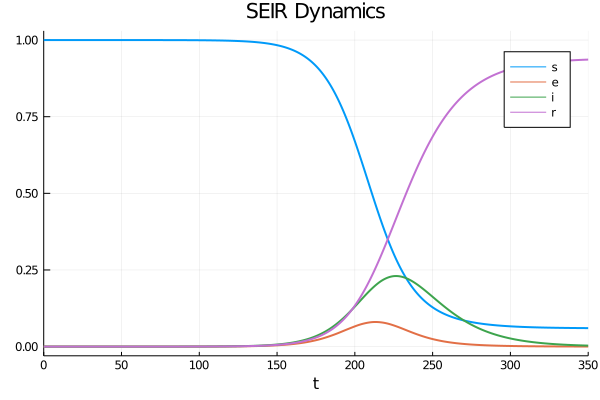

In [6]:
sol = solve(prob, Tsit5())
plot(sol, labels = ["s" "e" "i" "r"], title = "SEIR Dynamics", lw = 2)

We did not provide either a set of time steps or a `dt` time step size to the `solve`.  Most accurate and high-performance ODE solvers appropriate for this problem use adaptive time-stepping, changing the step size based the degree of curvature in the derivatives.

Or, as an alternative visualization, the proportions in each state over time

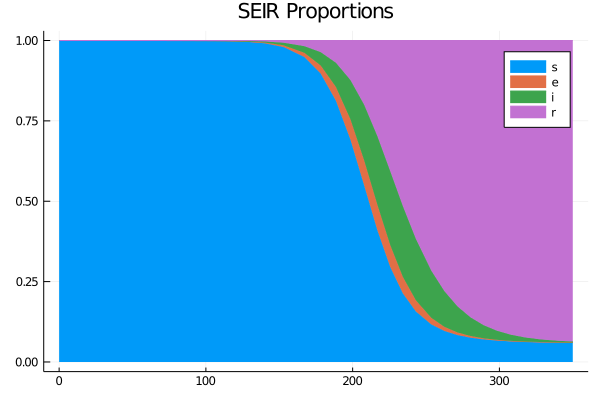

In [7]:
areaplot(sol.t, sol', labels = ["s" "e" "i" "r"], title = "SEIR Proportions")

While maintaining the core system of ODEs in $ (s, e, i, r) $, we will extend the basic model to enable some policy experiments and calculations of aggregate values.

### Extending the Model

First, we can consider some additional calculations such as the cumulative caseload (i.e., all those who have or have had the infection) as $ c = i + r $.  Differentiating that expression and substituting from the time-derivatives of $ i(t) $ and $ r(t) $ yields $ \frac{d c}{d t} = \sigma e $.

We will assume that the transmission rate follows a process with a reversion to a value $ \bar{R}_0(t) $ which could conceivably be influenced by policy.  The intuition is that even if the targeted $ \bar{R}_0(t) $ was changed through social distancing/etc., lags in behavior and implementation would smooth out the transition, where $ \eta $ governs the speed of $ R_0(t) $ moves towards $ \bar{R}_0(t) $.


<a id='equation-rode'></a>
$$
\begin{aligned}
\frac{d R_0}{d t} &= \eta (\bar{R}_0 - R_0)\\
\end{aligned} \tag{3}
$$

Finally, let $ \delta $ be the mortality rate, which we will leave constant.  The cumulative deaths can be integrated through the flow $ \gamma i $ entering the “Removed” state.

Define the cumulative number of deaths as $ D(t) $ with the proportion $ d(t) := D(t)/N $.


<a id='equation-mode'></a>
$$
\begin{aligned}\\
\frac{d}{d t}d(t) &= \delta \gamma  i
\end{aligned} \tag{4}
$$

While we could integrate the deaths given the solution to the model ex-post, it is more convenient to use the integrator built into the ODE solver.  That is, we add $ \frac{d}{dt} d(t) $ rather than calculating $ d(t) = \int_0^t \delta \gamma\, i(\tau) d \tau $ ex-post.

This is a common trick when solving systems of ODEs.  While equivalent in principle to using the appropriate quadrature scheme, this becomes especially convenient when adaptive time-stepping algorithms are used to solve the ODEs (i.e. there is not a regular time grid). Note that when doing so, $ d(0) = \int_0^0 \delta \gamma i(\tau) d \tau = 0 $ is the initial condition.

The system [(2)](#equation-seir-system) and the supplemental equations can be written in vector form $ x := [s, e, i, r, R₀, c, d] $ with parameter tuple $ p := (\sigma, \gamma, \eta, \delta, \bar{R}_0(\cdot)) $

Note that in those parameters, the targeted reproduction number, $ \bar{R}_0(t) $, is an exogenous function.

The model is then $ \frac{d x}{d t} = F(x,t) $  where,


<a id='equation-dfcv'></a>
$$
F(x,t) := \begin{bmatrix}
    -\gamma \, R_0 \, s \,  i
    \\
    \gamma \, R_0 \,  s \,  i  - \sigma e
    \\
    \sigma \, e  - \gamma i
    \\
    \gamma i
    \\
    \eta (\bar{R}_0(t) - R_0)
    \\
    \sigma e
    \\
    \delta \, \gamma \, i
\end{bmatrix} \tag{5}
$$

Note that if $ \bar{R}_0(t) $ is time-invariant, then $ F(x, t) $ is time-invariant as well.

### Parameters

The parameters, $ \sigma, \delta, $ and $ \gamma $ should be thought of as parameters determined from biology and medical technology, and independent of social interactions.

As in Atkeson’s note, we set

- $ \sigma = 1/5.2 $ to reflect an average incubation period of 5.2 days.  
- $ \gamma = 1/18 $ to match an average illness duration of 18 days.  
- $ \bar{R}_0(t) = R_0(0) = 1.6 $ to match a **basic reproduction number** of 1.6, and initially time-invariant  
- $ \delta = 0.01 $ for a one-percent mortality rate  


As we will initially consider the case where $ R_0(0) = \bar{R}_0(0) $, the parameter $ \eta $ will not influence the first experiment.

## Implementation

First, construct our $ F $ from [(5)](#equation-dfcv)

In [8]:
function F(x, p, t)
    s, e, i, r, R₀, c, d = x
    @unpack σ, γ, R̄₀, η, δ = p

    return [-γ*R₀*s*i;        # ds/dt
            γ*R₀*s*i -  σ*e;  # de/dt
            σ*e - γ*i;        # di/dt
            γ*i;              # dr/dt
            η*(R̄₀(t, p) - R₀);# dR₀/dt
            σ*e;              # dc/dt
            δ*γ*i;            # dd/dt
            ]
end;

This function takes the vector `x` of states in the system and extracts the fixed parameters passed into the `p` object.

The only confusing part of the notation is the `R̄₀(t, p)` which evaluates the `p.R̄₀` at this time (and also allows it to depend on the `p` parameter).

### Parameters

The baseline parameters are put into a named tuple generator (see previous lectures using [Parameters.jl](https://github.com/mauro3/Parameters.jl)) with default values discussed above.

In [9]:
p_gen = @with_kw ( T = 550.0, γ = 1.0 / 18, σ = 1 / 5.2, η = 1.0 / 20,
                R₀_n = 1.6, δ = 0.01, N = 3.3E8,
                R̄₀ = (t, p) -> p.R₀_n);

Note that the default $ \bar{R}_0(t) $ function always equals $ R_{0n} $ – a parameterizable natural level of $ R_0 $ used only by the `R̄₀` function

Setting initial conditions, we choose a fixed $ s, i, e, r $, as well as $ R_0(0) = R_{0n} $ and $ m(0) = 0.01 $

In [10]:
p = p_gen()  # use all default parameters

i_0 = 1E-7
e_0 = 4.0 * i_0
s_0 = 1.0 - i_0 - e_0

x_0 = [s_0, e_0, i_0, 0.0, p.R₀_n, 0.0, 0.0]
tspan = (0.0, p.T)
prob = ODEProblem(F, x_0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9999995, 4.0e-7, 1.0e-7, 0.0, 1.6, 0.0, 0.0]

The `tspan` of `(0.0, p.T)` determines the $ t $ used by the solver.  The time scale needs to be consistent with the arrival
rate of the transition probabilities (i.e. the $ \gamma, \sigma $ were chosen based on daily data, so the unit of $ t $ is a day).

The time period we investigate will be 550 days, or around 18 months:

## Experiments

Let’s run some experiments using this code.

In [11]:
sol = solve(prob, Tsit5())
@show length(sol.t);

length(sol.t) = 45


We see that the adaptive time-stepping used approximately 45 time-steps to solve this problem to the desired accuracy.  Evaluating the solver at points outside of those time-steps uses an interpolator consistent with the solution to the ODE.

While it may seem that 45 time intervals is extremely small for that range, for much of the $ t $, the functions are very flat - and hence adaptive time-stepping algorithms can move quickly and interpolate accurately.

The solution object has [built in](https://docs.sciml.ai/stable/basics/plot/) plotting support.

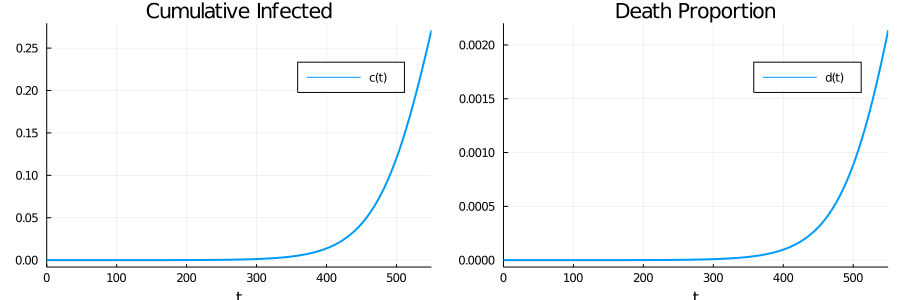

In [12]:
plot(sol, vars = [6, 7], label = ["c(t)" "d(t)"], lw = 2,
     title = ["Cumulative Infected" "Death Proportion"],
     layout = (1,2), size = (900, 300))

A few more comments:

- If you want to ensure that there are specific points that the adaptive-time stepping must include (e.g. at known discontinuities) use [tstops](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Output-Control-1).  
- The built-in plots for the solutions provide all of the [attributes](https://docs.juliaplots.org/latest/tutorial/) in [Plots.jl](https://github.com/JuliaPlots/Plots.jl).  
- See [here](https://docs.sciml.ai/stable/basics/solution/) for details on analyzing the solution and extracting the output.  

### Experiment 1: Constant Reproduction Case

Let’s start with the case where $ \bar{R}_0(t) = R_{0n} $ is constant.

We calculate the time path of infected people under different assumptions of $ R_{0n} $:

In [13]:
R₀_n_vals = range(1.6, 3.0, length = 6)
sols = [solve(ODEProblem(F, x_0, tspan, p_gen(R₀_n = R₀_n)),
              Tsit5(), saveat=0.5) for R₀_n in R₀_n_vals];

Here we chose `saveat=0.5` to get solutions that were evenly spaced every `0.5`.

Changing the saved points is just a question of storage/interpolation, and does not change the adaptive time-stepping of the solvers.

Let’s plot current cases as a fraction of the population.

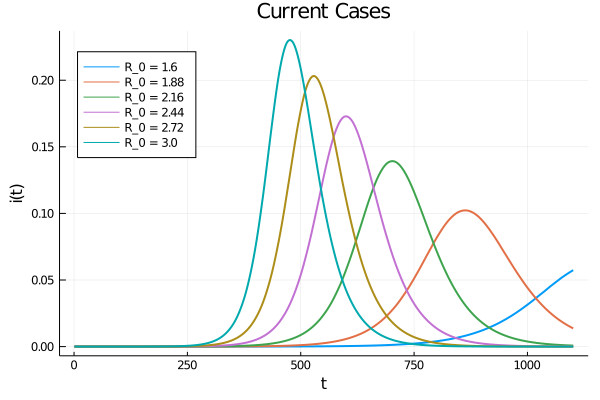

In [14]:
labels = permutedims(["R_0 = $r" for r in R₀_n_vals])
infecteds = [sol[3,:] for sol in sols]
plot(infecteds, label=labels, legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "i(t)", title = "Current Cases")

As expected, lower effective transmission rates defer the peak of infections.

They also lead to a lower peak in current cases.

Here is cumulative cases, as a fraction of population:

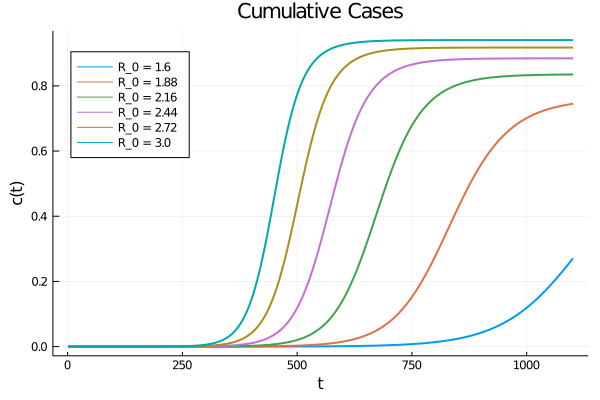

In [15]:
cumulative_infected = [sol[6,:] for sol in sols]
plot(cumulative_infected, label=labels ,legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "c(t)", title = "Cumulative Cases")

### Experiment 2: Changing Mitigation

Let’s look at a scenario where mitigation (e.g., social distancing) is
successively imposed, but the target (maintaining $ R_{0n} $) is fixed.

To do this, we start with $ R_0(0) \neq R_{0n} $ and examine the dynamics using the $ \frac{d R_0}{d t} = \eta (R_{0n} - R_0) $ ODE.

In the simple case, where $ \bar{R}_0(t) = R_{0n} $ is independent of the state, the solution to the ODE given an initial condition is $ R_0(t) = R_0(0) e^{-\eta t} + R_{0n}(1 - e^{-\eta t}) $

We will examine the case where $ R_0(0) = 3 $ and then it falls to $ R_{0n} = 1.6 $ due to the progressive adoption of stricter mitigation measures.

The parameter `η` controls the rate, or the speed at which restrictions are
imposed.

We consider several different rates:

In [16]:
η_vals = [1/5, 1/10, 1/20, 1/50, 1/100]
labels = permutedims(["eta = $η" for η in η_vals]);

Let’s calculate the time path of infected people, current cases, and mortality

In [17]:
x_0 = [s_0, e_0, i_0, 0.0, 3.0, 0.0, 0.0]
sols = [solve(ODEProblem(F, x_0, tspan, p_gen(η=η)), Tsit5(), saveat=0.5) for η in η_vals];

Next, plot the $ R_0 $ over time:

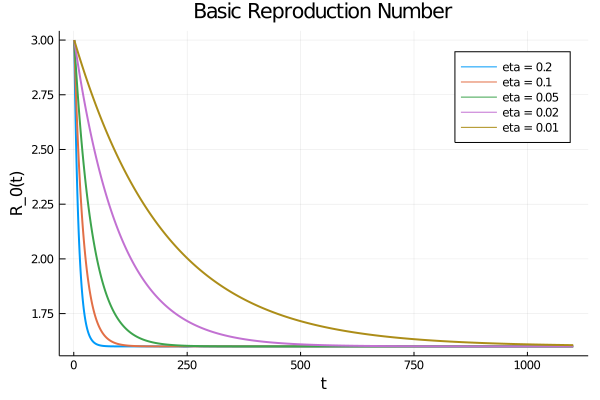

In [18]:
Rs = [sol[5,:] for sol in sols]
plot(Rs, label=labels, legend=:topright, lw = 2, xlabel = "t",
     ylabel = "R_0(t)", title = "Basic Reproduction Number")

Now let’s plot the number of infected persons and the cumulative number
of infected persons:

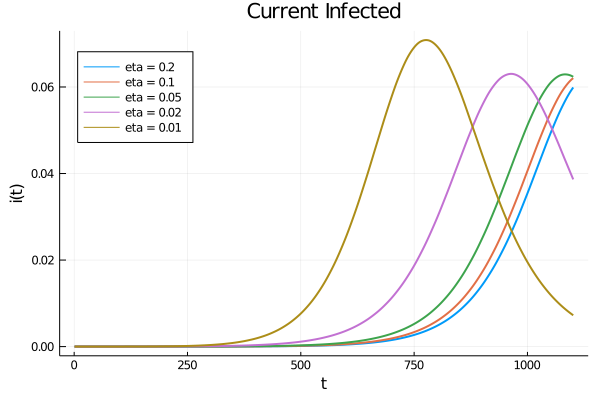

In [19]:
infecteds = [sol[3,:] for sol in sols]
plot(infecteds, label=labels, legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "i(t)", title = "Current Infected")

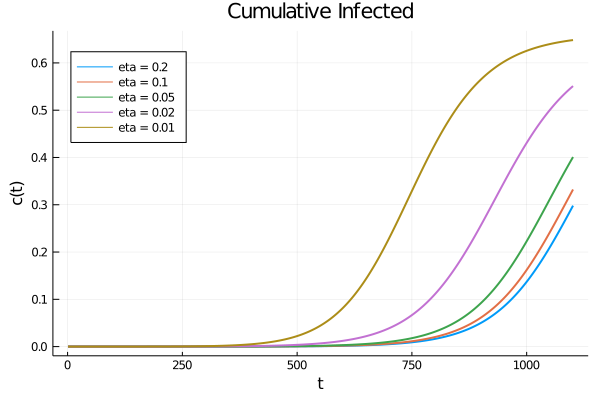

In [20]:
cumulative_infected = [sol[6,:] for sol in sols]
plot(cumulative_infected, label=labels ,legend=:topleft, lw = 2, xlabel = "t",
     ylabel = "c(t)", title = "Cumulative Infected")

## Ending Lockdown

The following is inspired by [additional results](https://drive.google.com/file/d/1uS7n-7zq5gfSgrL3S0HByExmpq4Bn3oh/view) by Andrew Atkeson on the timing of lifting lockdown.

Consider these two mitigation scenarios:

1. choose $ \bar{R}_0(t) $ to target $ R_0(t) = 0.5 $ for 30 days and then $ R_0(t) = 2 $ for the remaining 17 months. This corresponds to lifting lockdown in 30 days.  
1. $ R_0(t) = 0.5 $ for 120 days and then $ R_0(t) = 2 $ for the remaining 14 months. This corresponds to lifting lockdown in 4 months.  


For both of these, we will choose a large $ \eta $ to focus on the case where rapid changes in the lockdown policy remain feasible.

The parameters considered here start the model with 25,000 active infections
and 75,000 agents already exposed to the virus and thus soon to be contagious.

In [21]:
R₀_L = 0.5  # lockdown
R̄₀_lift_early(t, p) = t < 30.0 ? R₀_L : 2.0
R̄₀_lift_late(t, p) = t < 120.0 ? R₀_L : 2.0
p_early = p_gen(R̄₀= R̄₀_lift_early, η = 10.0)
p_late = p_gen(R̄₀= R̄₀_lift_late, η = 10.0)


# initial conditions
i_0 = 25000 / p_early.N
e_0 = 75000 / p_early.N
s_0 = 1.0 - i_0 - e_0

x_0 = [s_0, e_0, i_0, 0.0, R₀_L, 0.0, 0.0] # start in lockdown

# create two problems, with rapid movement of R₀(t) towards R̄₀(t)
prob_early = ODEProblem(F, x_0, tspan, p_early)
prob_late = ODEProblem(F, x_0, tspan, p_late)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9996969696969696, 0.00022727272727272727, 7.575757575757576e-5, 0.0, 0.5, 0.0, 0.0]

Unlike the previous examples, the $ \bar{R}_0(t) $ functions have discontinuities which might occur.  We can improve the efficiency of the adaptive time-stepping methods by telling them to include a step exactly at those points by using `tstops`

Let’s calculate the paths:

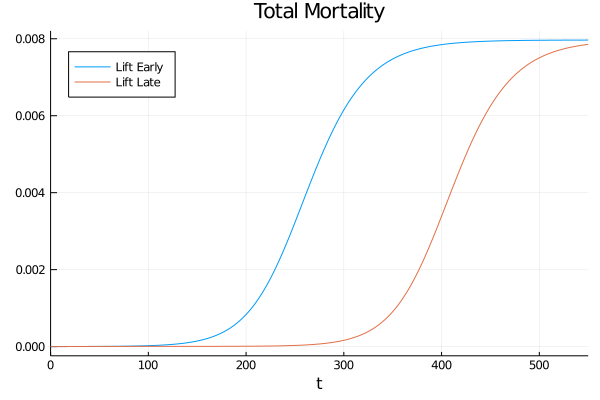

In [22]:
sol_early = solve(prob_early, Tsit5(), tstops = [30.0, 120.0])
sol_late = solve(prob_late, Tsit5(), tstops = [30.0, 120.0])
plot(sol_early, vars = [7], title = "Total Mortality", label = "Lift Early", legend = :topleft)
plot!(sol_late, vars = [7], label = "Lift Late")

Next we examine the daily deaths, $ \frac{d D(t)}{dt} = N \delta \gamma i(t) $.

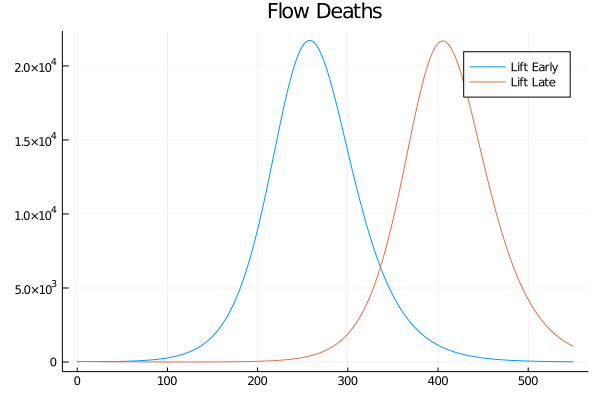

In [23]:
flow_deaths(sol, p) = p.N * p.δ * p.γ * sol[3,:]

plot(sol_early.t, flow_deaths(sol_early, p_early), title = "Flow Deaths", label = "Lift Early")
plot!(sol_late.t, flow_deaths(sol_late, p_late), label = "Lift Late")

Pushing the peak of curve further into the future may reduce cumulative deaths
if a vaccine is found, or allow health authorities to better smooth the caseload.

### Randomness

Despite its richness, the model above is fully deterministic.  The policy $ \bar{R}_0(t) $ could change over time, but only in predictable ways.

One way that randomness can lead to aggregate fluctuations is the granularity that comes through the discreteness of individuals.  This topic, the connection between SDEs and the Langevin equations typically used in the approximation of chemical reactions in well-mixed media is explored in further lectures on continuous time Markov chains.

Instead, in the [next lecture](covid_sde.html), we will concentrate on randomness that comes from aggregate changes in behavior or policy.